In [1]:
# %%
from utils import load_crypto_dir, preprocess_ohlc, align_two
from trade import Exchange, CointBacktester
from plot import (
    plot_beta_and_pvalue,
    plot_equity_with_trades,
    plot_trade_residual_spread_paths,
    heatmap_from_pivot,
    heatmap_from_pivot_mask_nan,
    _trade_segments_from_daily,
)
from metrics import summarize_performance, summarize_close_reasons, equity_to_returns
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

In [2]:
data_dir = "/home/jim/CryptoPairTrading/data/futures"
start_date = start_date = (datetime(2023, 1, 1) - timedelta(days=119)).strftime("%Y-%m-%d")
end_date = "2024-12-31"

df_dict = load_crypto_dir(data_dir, start_date=start_date, end_date=end_date)
sorted(df_dict.keys())

['1INCHUSDT_1h',
 'BANDUSDT_1h',
 'C98USDT_1h',
 'CELOUSDT_1h',
 'DOGEUSDT_1h',
 'DOTUSDT_1h',
 'KSMUSDT_1h',
 'MINAUSDT_1h',
 'OPUSDT_1h']

In [3]:
key1 = "KSMUSDT_1h"
key2 = "CELOUSDT_1h"

df1 = preprocess_ohlc(df_dict[key1])
df2 = preprocess_ohlc(df_dict[key2])

coint_var = "log_close"
merged_df = align_two(df1, df2, coint_var=coint_var)
merged_df.head()

,open_time,log_close_1,close_1,log_close_2,close_2
0,2022-09-04 00:00:00,3.891820,49.00,-0.189951,0.827
1,2022-09-04 01:00:00,3.893248,49.07,-0.191161,0.826
2,2022-09-04 02:00:00,3.897518,49.28,-0.186330,0.830
3,2022-09-04 03:00:00,3.892840,49.05,-0.187535,0.829
4,2022-09-04 04:00:00,3.897924,49.30,-0.186330,0.830


In [4]:
ex = Exchange(merged_df, coint_var=coint_var)

start = merged_df["open_time"].min()
end = merged_df["open_time"].max()

bt = CointBacktester(
    exchange=ex,
    start_time=start,
    end_time=end,
    coint_var=coint_var,
    train_len=120 * 24,  # window length in bars
    gap=24,  # decision cadence in bars
    pval_alpha=0.05,
    entry_k=1.5,
    exit_k=0.5,
    relaxed_pval_alpha=0.20,     # optional
    stop_k=1.5,                  # optional
    stop_loss_cooling_days=5.0,  # optional
    initial_balance=1_000_000.0,
    trade_frac=0.05,
    margin_rate=0.10,
    fee_rate=5e-4,
)

daily, fits = bt.run()
fits.head()

,fit_time,beta0,beta1_log,sigma_log,p_value,entry_allowed,train_start,train_end,valid_from_idx,valid_to_idx,reason,fixed_beta_p,fixed_beta_sigma,fixed_beta_thr,fixed_beta_train_start,fixed_beta_train_end
0,2023-01-02,3.981946,1.068738,0.077075,0.004046,True,2022-09-04 01:00:00,2023-01-02,2880,2903,periodic_decision,NaN,NaN,NaN,NaT,NaT
1,2023-01-06,3.971418,1.060654,0.075268,0.001781,True,2022-09-08 01:00:00,2023-01-06,2976,2999,periodic_decision,NaN,NaN,NaN,NaT,NaT
2,2023-01-07,3.967432,1.054878,0.074167,0.001738,True,2022-09-09 01:00:00,2023-01-07,3000,3023,periodic_decision,NaN,NaN,NaN,NaT,NaT
3,2023-01-08,3.963227,1.049180,0.073354,0.002752,True,2022-09-10 01:00:00,2023-01-08,3024,3047,periodic_decision,NaN,NaN,NaN,NaT,NaT
4,2023-01-09,3.959379,1.044030,0.072802,0.001642,True,2022-09-11 01:00:00,2023-01-09,3048,3071,periodic_decision,NaN,NaN,NaN,NaT,NaT


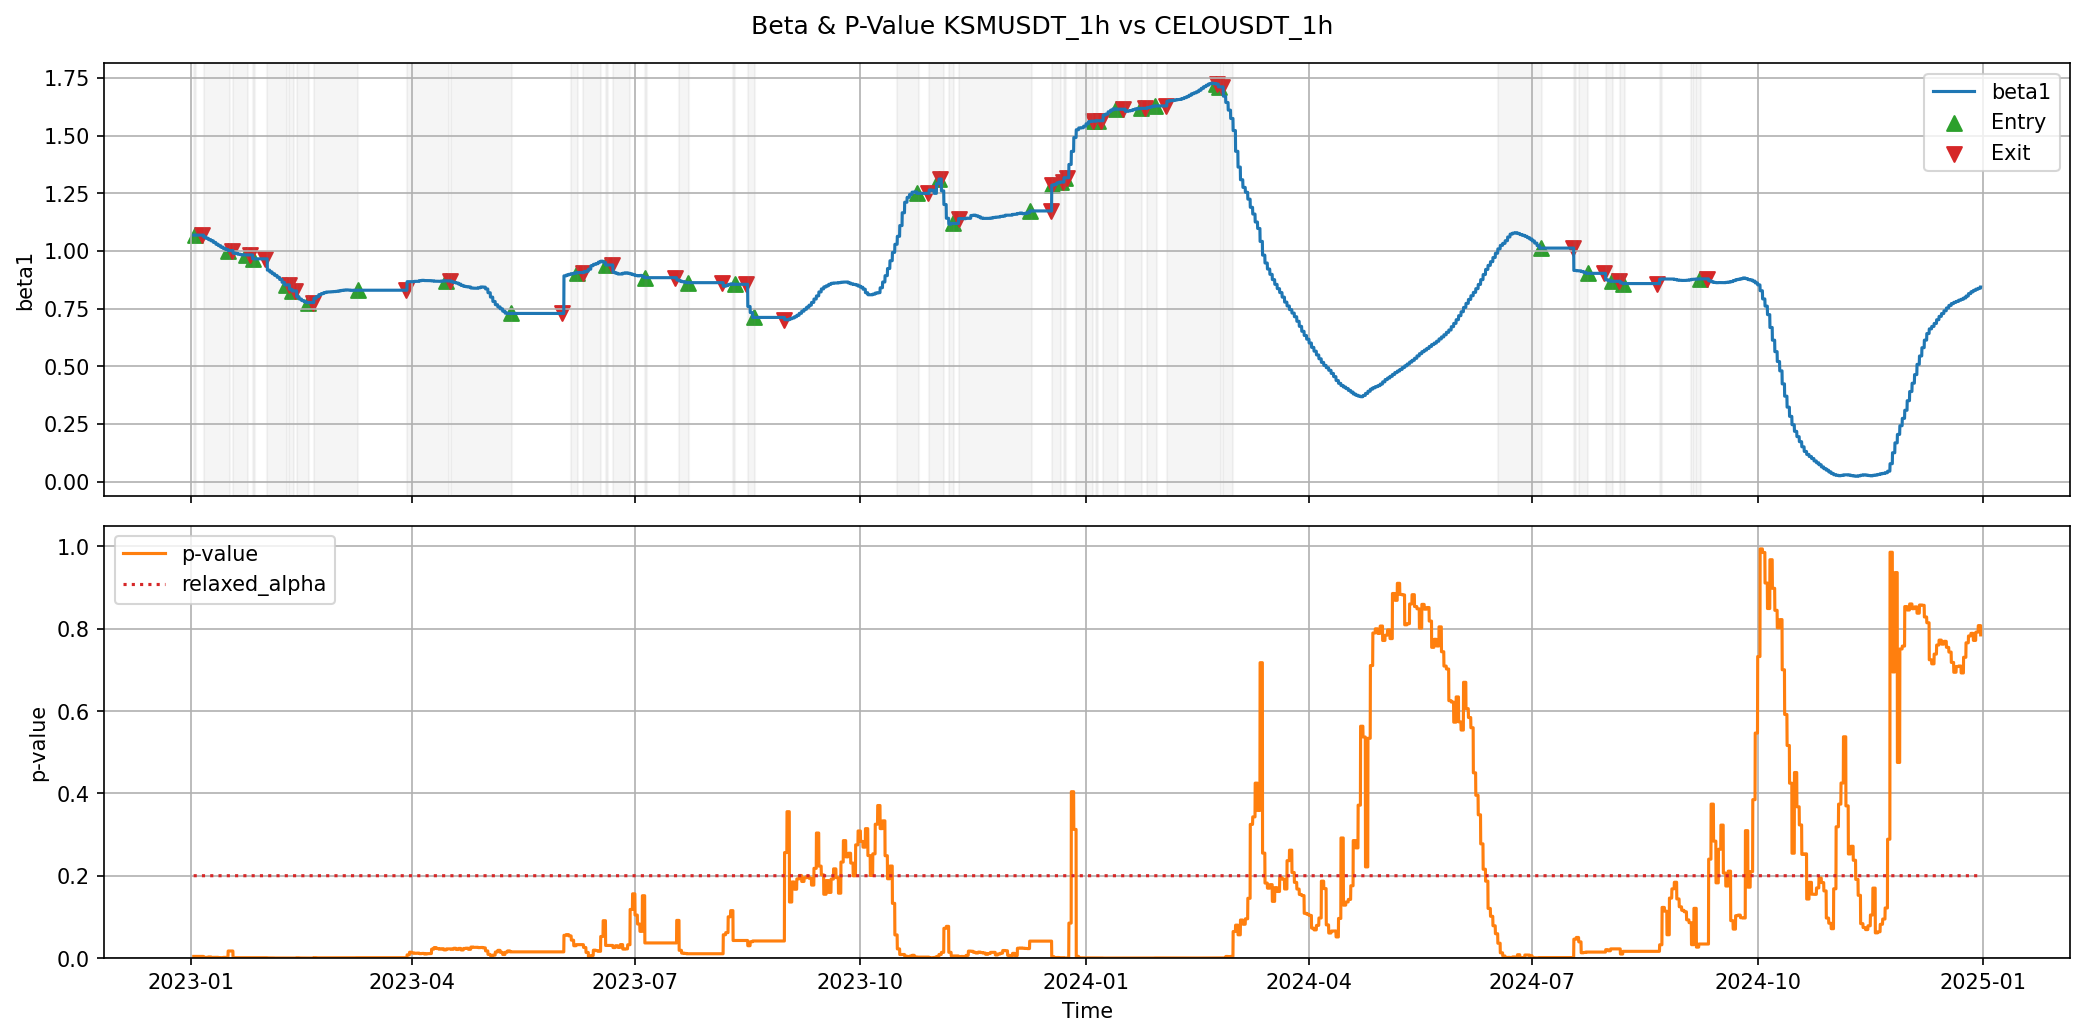

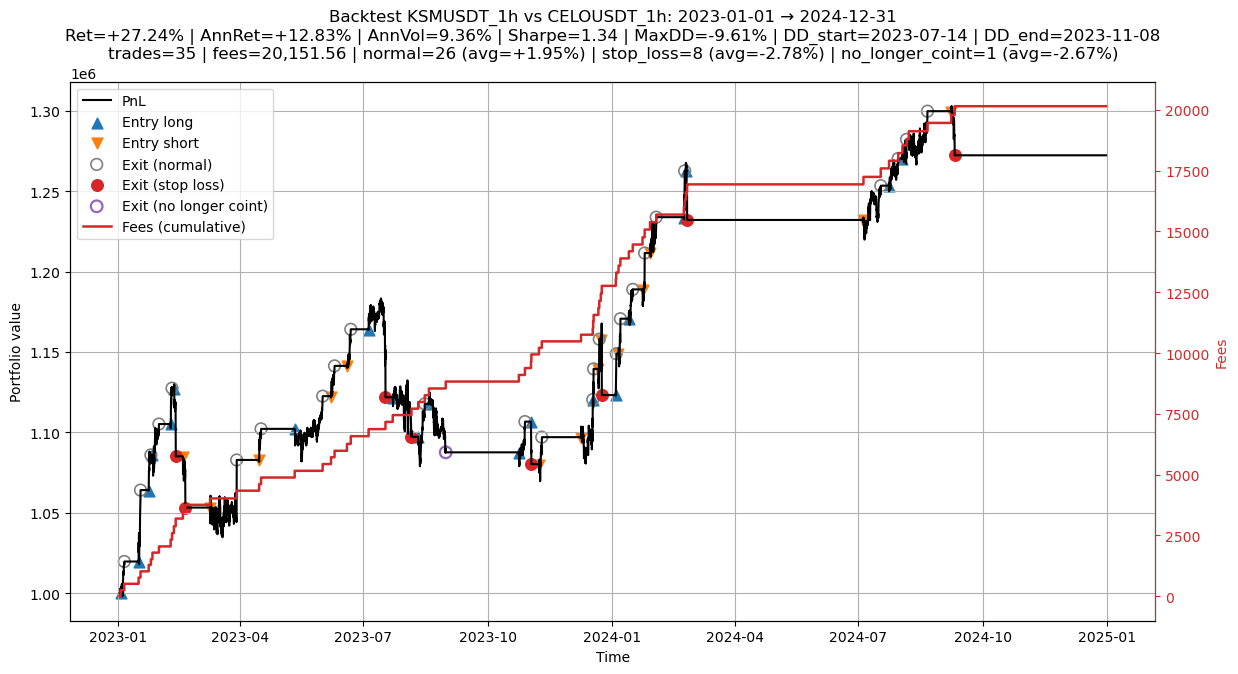

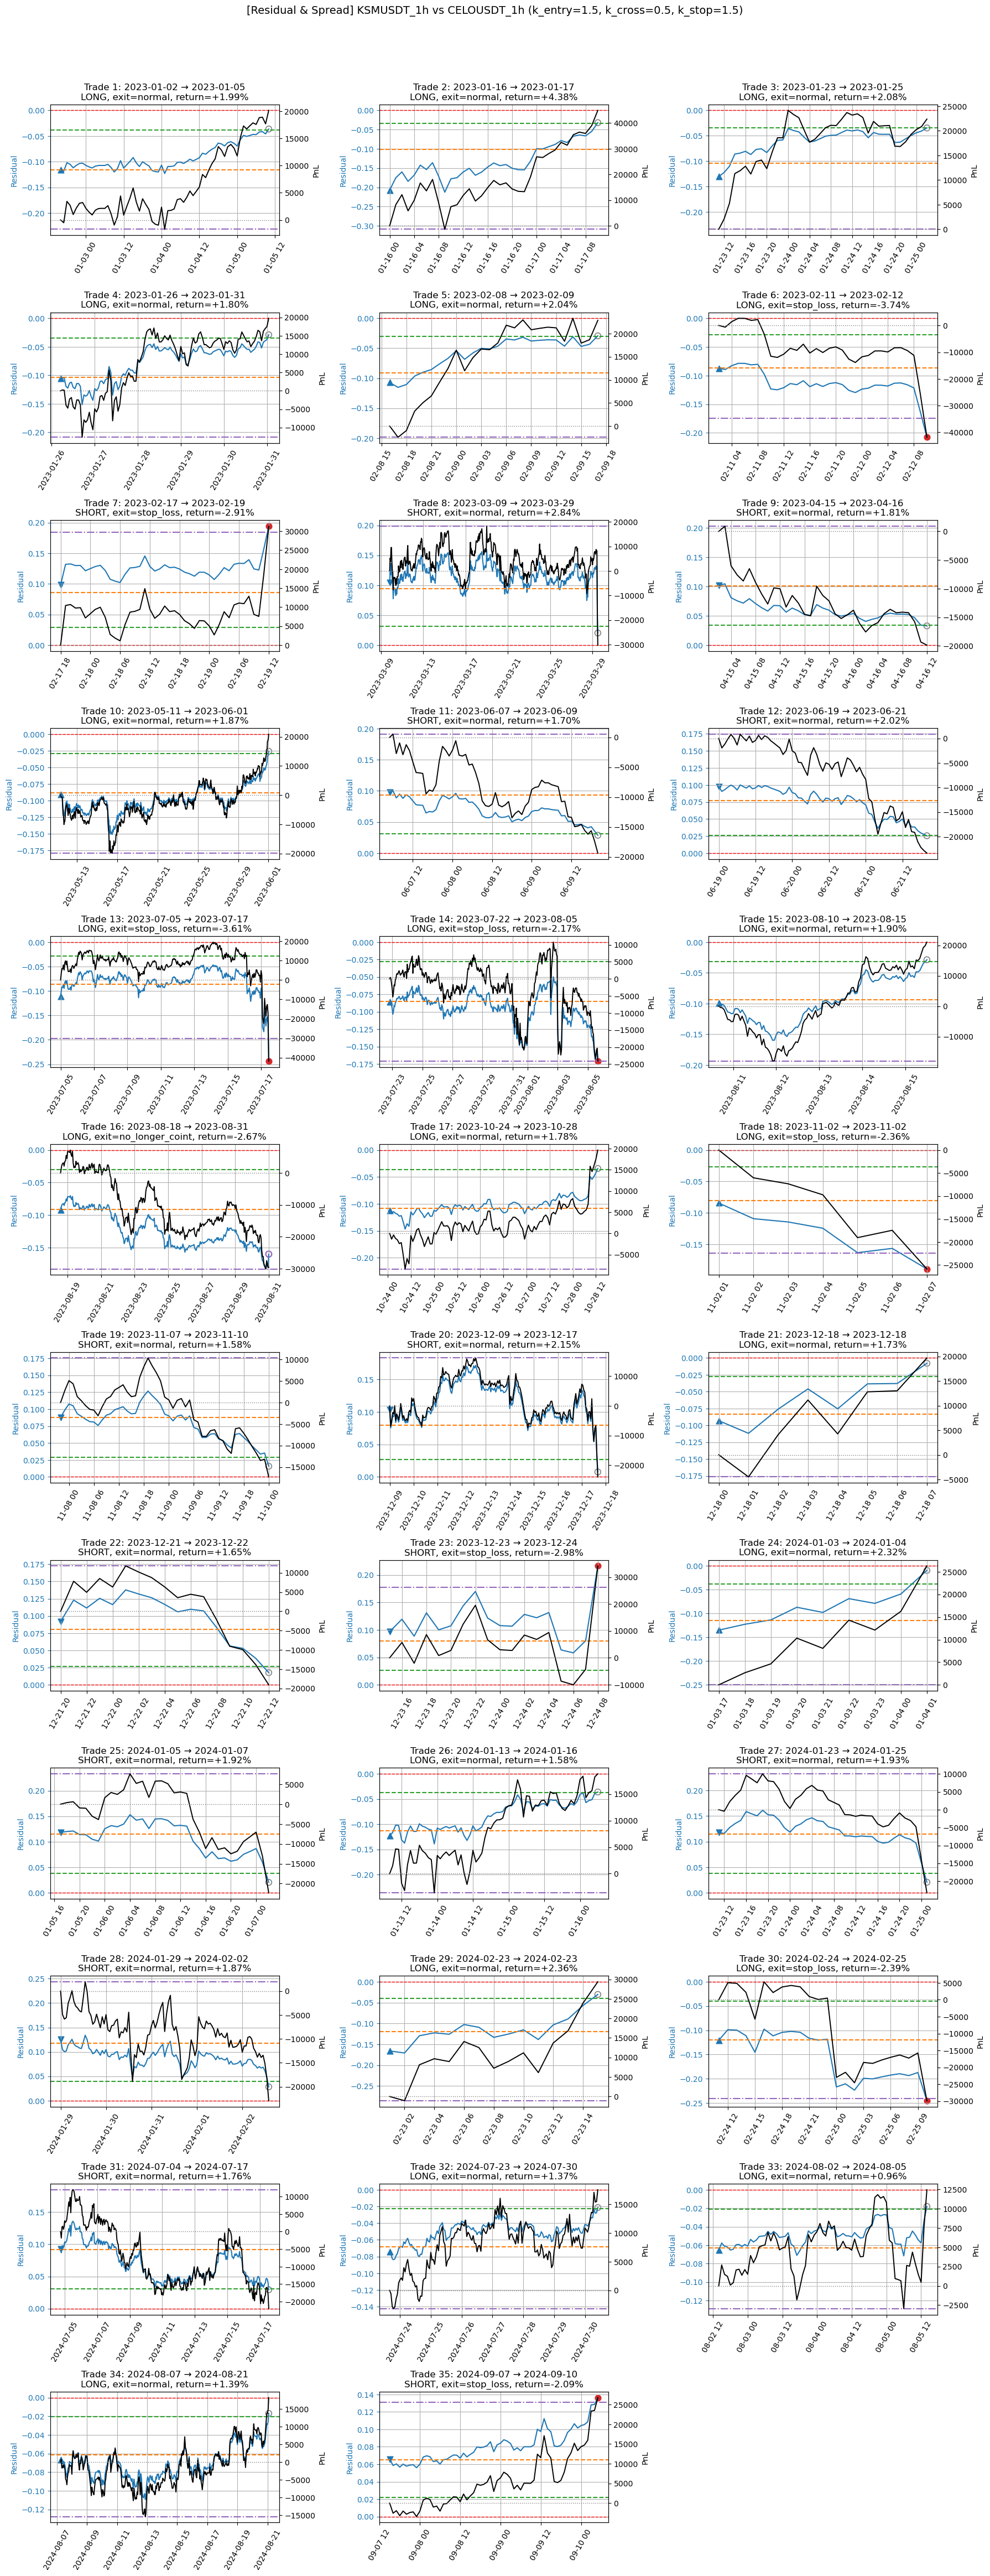

In [5]:
plot_beta_and_pvalue(daily, title=f"Beta & P-Value {key1} vs {key2}")

plot_equity_with_trades(daily, title=f"Backtest {key1} vs {key2}")

plot_trade_residual_spread_paths(
    daily,
    prices_df=merged_df[["open_time", "close_1", "close_2"]],
    entry_k=bt.entry_k,
    exit_cross_k=bt.exit_k,
    stop_k=bt.stop_k,
    max_trades=None,
    title_prefix=f"[Residual & Spread] {key1} vs {key2}",
)

In [ ]:
# Grid search helpers
bars_per_day = 24
INITIAL_BAL = 1_000_000.0
FIG_ROOT = Path("figures")
FIG_ROOT.mkdir(exist_ok=True)
prices_for_plots = merged_df[["open_time", "close_1", "close_2"]]


def run_once_return_daily(
    train_len_days: int, entry_k: float, gap_bars: int = 24
) -> tuple[pd.DataFrame, pd.DataFrame, CointBacktester]:
    bt = CointBacktester(
        exchange=ex,
        start_time=start,
        end_time=end,
        coint_var=coint_var,
        train_len=int(train_len_days * bars_per_day),
        gap=gap_bars,
        pval_alpha=0.05,
        entry_k=entry_k,
        exit_k=0.5,
        relaxed_pval_alpha=0.20,
        stop_k=1.5,
        stop_loss_cooling_days=5.0,
        initial_balance=INITIAL_BAL,
        trade_frac=0.05,
        margin_rate=0.10,
        fee_rate=5e-4,
    )
    daily_i, fits_i = bt.run()
    return daily_i, fits_i, bt


def _safe_float(value: object) -> float:
    try:
        if value is None:
            return float("nan")
        val = float(value)
        return val if np.isfinite(val) else float("nan")
    except (TypeError, ValueError):
        return float("nan")


def _trade_duration_stats(daily_df: pd.DataFrame) -> tuple[int, float, float]:
    segs = _trade_segments_from_daily(daily_df)
    if not segs:
        return 0, float("nan"), float("nan")

    durations = []
    for seg in segs:
        entry_time = pd.to_datetime(seg.get("entry_time"))
        exit_time = pd.to_datetime(seg.get("exit_time"))
        if pd.isna(entry_time) or pd.isna(exit_time):
            continue
        delta_days = (exit_time - entry_time).total_seconds() / (24 * 3600.0)
        durations.append(delta_days)

    avg_days = float(np.mean(durations)) if durations else float("nan")
    median_days = float(np.median(durations)) if durations else float("nan")
    return len(segs), avg_days, median_days


def _combo_slug(train_len_days: int, entry_k: float) -> str:
    return f"train_{train_len_days:03d}_entry_{entry_k:.1f}".replace(".", "p")


train_lens_days = list(range(30, 121, 30))
entry_ks = [round(x, 1) for x in np.arange(1.0, 2.5 + 1e-9, 0.5)]

grid_rows: list[dict] = []
for tl in tqdm(train_lens_days, desc="train_len_days"):
    for ek in tqdm(entry_ks, desc=f"entry_k (train={tl}d)", leave=False):
        daily_i, fits_i, bt_i = run_once_return_daily(train_len_days=tl, entry_k=ek, gap_bars=24)

        try:
            perf_i, _ = summarize_performance(daily_i, pnl_col="pnl", time_col="time")
        except Exception:
            perf_i = {}

        n_trades, avg_revert_days, median_revert_days = _trade_duration_stats(daily_i)

        final_equity = float(daily_i["pnl"].iloc[-1]) if len(daily_i) else float("nan")
        final_pnl = final_equity - INITIAL_BAL
        ret_pct = _safe_float(perf_i.get("Ret")) if perf_i else (
            final_pnl / INITIAL_BAL if np.isfinite(final_pnl) else float("nan")
        )

        combo_dir = FIG_ROOT / _combo_slug(tl, ek)
        combo_dir.mkdir(parents=True, exist_ok=True)
        title_suffix = f"train={tl}d | entry_k={ek:.1f}"

        plot_equity_with_trades(
            daily_i,
            title=f"Backtest {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "equity.png"),
        )
        plot_beta_and_pvalue(
            daily_i,
            title=f"Beta & P-Value {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "beta_pvalue.png"),
        )
        plot_trade_residual_spread_paths(
            daily_i,
            prices_df=prices_for_plots,
            entry_k=bt_i.entry_k,
            exit_cross_k=bt_i.exit_k,
            stop_k=bt_i.stop_k,
            max_trades=None,
            title_prefix=f"[Residual & Spread] {key1} vs {key2} ({title_suffix})",
            save_path=str(combo_dir / "residual_spread.png"),
        )

        grid_rows.append(
            {
                "train_len_days": tl,
                "entry_k": ek,
                "n_trades": n_trades,
                "avg_revert_days": avg_revert_days,
                "median_revert_days": median_revert_days,
                "final_equity": final_equity,
                "final_pnl": final_pnl,
                "return_pct": ret_pct,
                "ann_ret": _safe_float(perf_i.get("AnnRet")) if perf_i else float("nan"),
                "ann_vol": _safe_float(perf_i.get("AnnVol")) if perf_i else float("nan"),
                "sharpe": _safe_float(perf_i.get("Sharpe")) if perf_i else float("nan"),
                "max_drawdown": _safe_float(perf_i.get("MaxDrawdown")) if perf_i else float("nan"),
            }
        )

results_df = (
    pd.DataFrame(grid_rows)
    .sort_values("sharpe", ascending=False, na_position="last")
    .reset_index(drop=True)
)
results_df


train_len_days:   0%|          | 0/4 [00:00<?, ?it/s]

Saved: figures/train_030_entry_1p0/beta_pvalue.png


Saved: figures/train_030_entry_1p0/residual_spread.png
Saved: figures/train_030_entry_1p5/beta_pvalue.png


Saved: figures/train_030_entry_1p5/residual_spread.png
Saved: figures/train_030_entry_2p0/beta_pvalue.png


Saved: figures/train_030_entry_2p0/residual_spread.png
Saved: figures/train_030_entry_2p5/beta_pvalue.png


train_len_days:  25%|██▌       | 1/4 [01:45<05:17, 105.96s/it]

Saved: figures/train_030_entry_2p5/residual_spread.png


Saved: figures/train_060_entry_1p0/beta_pvalue.png


Saved: figures/train_060_entry_1p0/residual_spread.png
